In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product

%matplotlib widget
from IPython.display import HTML
HTML('''<style>.jupyter-matplotlib {background-color: #000;}.widget-label{color: #fff;}.jupyter-matplotlib-header{color: #000!important;}.jupyter-button {background-color: #333;color: #fff;}</style>''')

Load the images

In [136]:
dataset_path = Path('dataset')
left_path = dataset_path / 'left'
right_path = dataset_path / 'right'

left_image_paths = sorted(left_path.glob('*.png'))
right_image_paths = sorted(right_path.glob('*.png'))

left_imges = []
right_images = []

for i, (left_image, right_image) in enumerate(zip(left_image_paths, right_image_paths)):
	left = cv2.imread(str(left_image))
	right = cv2.imread(str(right_image))
	left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
	right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
	left_imges.append(left)
	right_images.append(right)

Create the Charuco dictionary

In [3]:
squaresX = 11
squaresY = 8
square_size = 0.05 # meters
marker_size = square_size * 0.8 # meters
aruco_dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
board = cv2.aruco.CharucoBoard(
	(squaresX, squaresY),
	square_size,
	marker_size,
	aruco_dictionary
)

In [76]:
def create_charuco_board(squaresX, squaresY, square_size, marker_size, aruco_dictionary):
	marker_positions = []
	for j, i in product(range(squaresY), range(squaresX)):
		if not (i%2) ^ (j%2):
			marker_positions.append([
				[i*square_size, j*square_size, 0],
				[i*square_size + marker_size, j*square_size, 0],
				[i*square_size + marker_size, j*square_size + marker_size, 0],
				[i*square_size, j*square_size + marker_size, 0],
			])

	return cv2.aruco.Board(np.array(marker_positions, dtype=np.float32), aruco_dictionary, np.arange(len(marker_positions)).reshape(1, -1))
        

board = create_charuco_board(squaresX, squaresY, square_size, marker_size, aruco_dictionary)

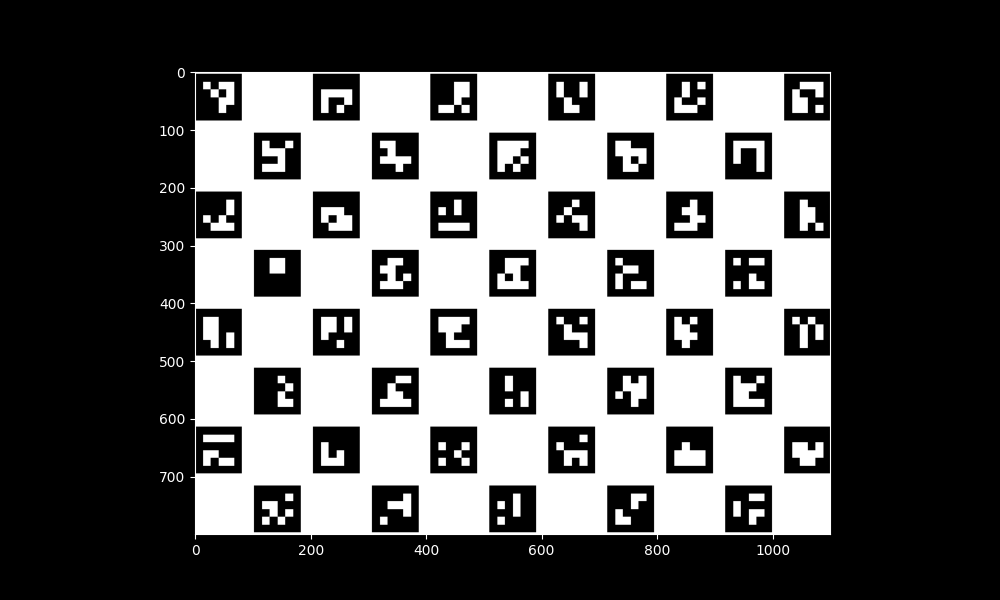

In [69]:
img = board.generateImage((squaresX * 100, squaresY * 100))
plt.figure(figsize=(10, 6))
plt.imshow(img, cmap='gray')

### Analyze one image

In [70]:
img = left_imges[0]
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [71]:
marker_corners, marker_ids, rejectedImgPoints = cv2.aruco.detectMarkers(
	img, aruco_dictionary)
marker_corners, marker_ids, refusd, recoverd = cv2.aruco.refineDetectedMarkers(
	img, board,
	marker_corners, marker_ids, rejectedCorners=rejectedImgPoints
)

print(f"Detected {len(marker_corners)} markers")

Detected 43 markers


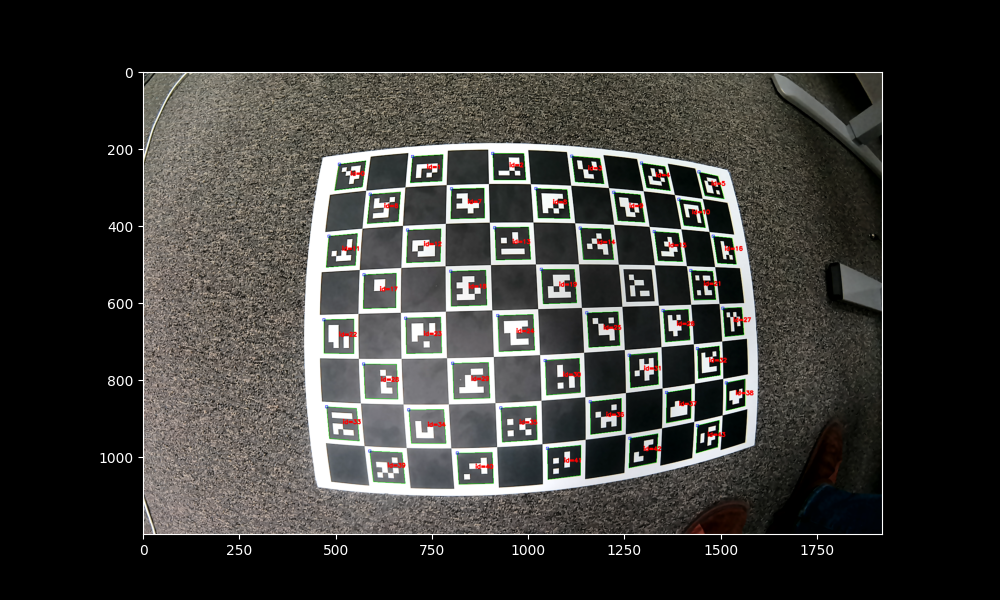

In [72]:
vis = cv2.aruco.drawDetectedMarkers(img.copy(), marker_corners, marker_ids)
plt.figure(figsize=(10, 6))
plt.imshow(vis)

In [98]:
obj_points, img_points = board.matchImagePoints(marker_corners, marker_ids)

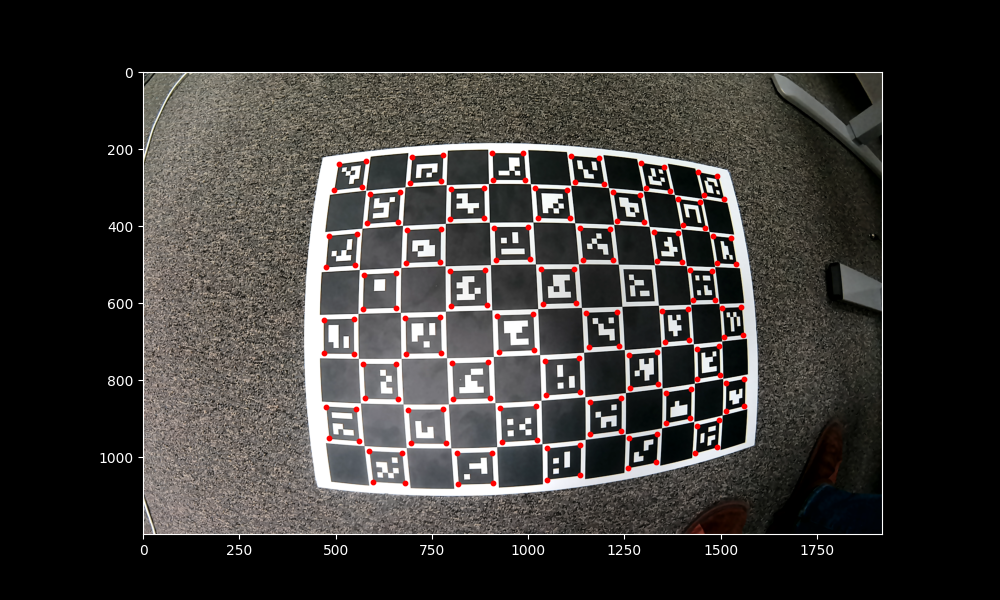

In [99]:
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.scatter(img_points[:, 0, 0], img_points[:, 0, 1], s=10, c='r')

### Analyze all images

In [120]:
def analyze_images(images):
	all_markers, all_obj_points, all_img_points, all_ids = [], [], [], []
	for image in images:
		marker_corners, marker_ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, aruco_dictionary)
		marker_corners, marker_ids, refusd, recoverd = cv2.aruco.refineDetectedMarkers(
			img, board,
			marker_corners, marker_ids, rejectedCorners=rejectedImgPoints
		)

		obj_points, img_points = board.matchImagePoints(marker_corners, marker_ids)

		all_markers.append(np.array(marker_corners))
		all_obj_points.append(obj_points)
		all_img_points.append(img_points)
		all_ids.append(marker_ids)

	return all_markers, all_obj_points, all_img_points, all_ids

In [132]:
all_left_markerks, all_left_obj_points, all_left_img_points, all_left_ids = analyze_images(left_imges)
all_right_markers, all_right_obj_points, all_right_img_points, all_right_ids = analyze_images(right_images)

In [133]:
all_common_obj_points = []
all_common_left_img_points = []
all_common_right_img_points = []
for left_ids, left_markerks, right_ids, right_markers in zip(all_left_ids, all_left_markerks, all_right_ids, all_right_markers):
	common_ids = np.intersect1d(left_ids, right_ids)
	common_left_markers = left_markerks[np.in1d(left_ids, common_ids)]
	common_right_markers = right_markers[np.in1d(right_ids, common_ids)]
	common_obj_points, common_left_img_points = board.matchImagePoints(common_left_markers, common_ids)
	common_obj_points, common_right_img_points = board.matchImagePoints(common_right_markers, common_ids)

	all_common_obj_points.append(common_obj_points)
	all_common_left_img_points.append(common_left_img_points)
	all_common_right_img_points.append(common_right_img_points)

In [129]:
retval_l, camera_matrix_l, dist_coeff_l, _, _ = cv2.fisheye.calibrate(all_left_obj_points, all_left_img_points, img_gray.shape[::-1], None, None)
retval_r, camera_matrix_r, dist_coeff_r, _, _ = cv2.fisheye.calibrate(all_right_obj_points, all_right_img_points, img_gray.shape[::-1], None, None)
print(f"{retval_l=}\n\n camera matrix L=\n{camera_matrix_l}\n\n dist coeff L={dist_coeff_l.flatten()}")
print(f"{retval_r=}\n\n camera matrix R=\n{camera_matrix_r}\n\n dist coeff R={dist_coeff_r.flatten()}")

retval_l=150.09294959124435

 camera matrix L=
[[725.80790506 -14.62362166 965.44498648]
 [  0.         715.07867399 593.7961854 ]
 [  0.           0.           1.        ]]

 dist coeff L=[-0.2108074   1.03083745 -1.15811968  0.26203384]
retval_r=165.52237126298138

 camera matrix R=
[[771.40131747   6.01506185 979.41537307]
 [  0.         774.46591961 594.2522491 ]
 [  0.           0.           1.        ]]

 dist coeff R=[-0.31154957  0.68883859 -0.12357872 -0.1052167 ]


In [151]:
flags = 0
flags |= cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
# flags |= cv2.fisheye.CALIB_CHECK_COND
flags |= cv2.fisheye.CALIB_FIX_SKEW
flags |= cv2.fisheye.CALIB_USE_INTRINSIC_GUESS

stereocalib_criteria = (cv2.TERM_CRITERIA_COUNT + cv2.TERM_CRITERIA_EPS, 1000, 1e-0)


cv2.fisheye.stereoCalibrate(
	all_common_obj_points, all_common_left_img_points, all_common_right_img_points,
	camera_matrix_l, dist_coeff_l, camera_matrix_r, dist_coeff_r, img_gray.shape[::-1],
	criteria=stereocalib_criteria, flags=flags
)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fisheye.cpp:1439: error: (-215:Assertion failed) fabs(norm_u1) > 0 in function 'cv::internal::InitExtrinsics'


In [114]:
all_common_obj_points[0]

array([[[ 851.,  938.]],

       [[ 941.,  936.]],

       [[ 943., 1017.]],

       [[ 856., 1019.]],

       [[ 629.,  932.]],

       [[ 712.,  936.]],

       [[ 719., 1016.]],

       [[ 637., 1011.]],

       [[1082.,  928.]],

       [[1167.,  921.]],

       [[1165., 1000.]],

       [[1082., 1009.]],

       [[ 440.,  914.]],

       [[ 507.,  922.]],

       [[ 517.,  998.]],

       [[ 448.,  989.]],

       [[1293.,  905.]],

       [[1366.,  895.]],

       [[1361.,  969.]],

       [[1290.,  982.]],

       [[ 730.,  826.]],

       [[ 819.,  826.]],

       [[ 823.,  914.]],

       [[ 735.,  913.]],

       [[ 964.,  824.]],

       [[1055.,  819.]],

       [[1056.,  906.]],

       [[ 967.,  911.]],

       [[ 520.,  818.]],

       [[ 597.,  823.]],

       [[ 603.,  906.]],

       [[ 526.,  900.]],

       [[ 350.,  804.]],

       [[ 410.,  810.]],

       [[ 417.,  889.]],

       [[ 356.,  880.]],

       [[1192.,  810.]],

       [[1272.,  803.]],

       [[127

##### References
- https://answers.opencv.org/question/213931/assertion-failed-abs_max-threshold-in-function-stereocalibrate/
- https://answers.opencv.org/question/67855/opencv-error-assertion-failed-abs_max-threshold-in-stereocalibrate/

In [124]:
print([len(p) for p in all_common_left_img_points])
print([len(p) for p in all_common_right_img_points])
print([len(p) for p in all_common_obj_points])

[172, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176]
[172, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176]
[172, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176]


In [ ]:
for left_img_points, right_img_points in zip(all_common_left_img_points, all_common_right_img_points):
	print(np.mean(np.sqrt(np.sum((left_img_points - right_img_points)**2, axis=-1))))

170.3967
161.06355
206.02672
214.29185
129.94926
153.4811
129.36243
117.52753
144.93968
125.13456
178.05647
178.9939
179.02206


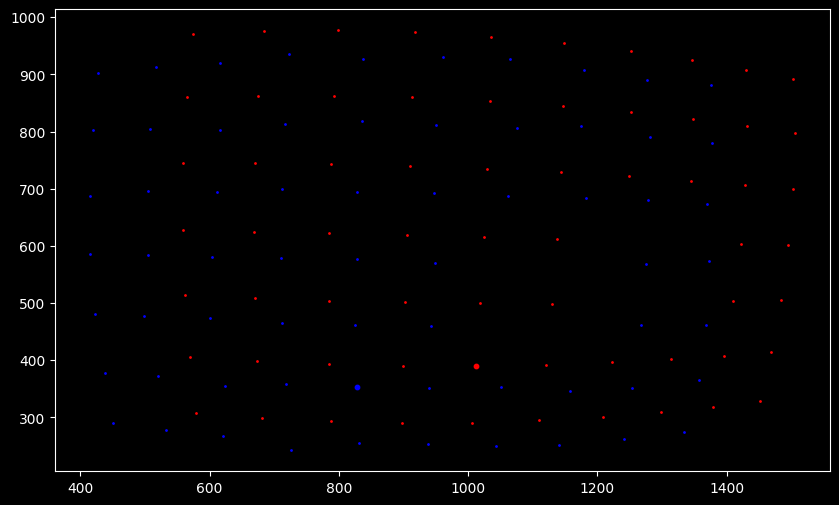

In [ ]:
plt.figure(figsize=(10, 6))
i = 50
plt.scatter(all_common_left_img_points[0][:, 0, 0], all_common_left_img_points[0][:, 0, 1], c='r', s=1)
plt.scatter(all_common_right_img_points[0][:, 0, 0], all_common_right_img_points[0][:, 0, 1], c='b', s=1)
plt.scatter(all_common_left_img_points[0][i, 0, 0], all_common_left_img_points[0][i, 0, 1], c='r', s=10)
plt.scatter(all_common_right_img_points[0][i, 0, 0], all_common_right_img_points[0][i, 0, 1], c='b', s=10)